## Food Mama project: 

In [1]:
import pandas as pd
import mama
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Datasets into Pandas dataframe

In [2]:
path = "datasets/"
files = os.listdir(path)

dfs = []
for file in files:
    filename = file.split("_")
    dfs.append(filename[0])
    exec(dfs[-1] + '= pd.read_csv(path + file)')

print("Name of the dataframes created: ", *dfs, sep="\n")

Name of the dataframes created: 
food
item
recipe


In [3]:
recipe.head()

,id,title,servings,ingredients,instructions,created_at,updated_at,recommendable,status,origin,link,rating
0,9,"Salade mâche, jambon de Bayonne, mozzarella",4,4 bonne poignée de mâche \r\n40 tomate cerise ...,"Après avoir coupé en dés la mozzarella, couper...",2017-12-14 14:56:37.166524,2018-10-05 09:16:42.390163,NaN,dismissed,www.marmiton.org,http://www.marmiton.org/recettes/recette_salad...,limit
1,10,Ciabattina al pesto,1,Ciabattina\r\nJambon de Parme\r\nTomates confi...,Ouvrir le pain Ciabattina en deux et tartiner ...,2017-12-14 14:56:46.270433,2018-10-05 09:16:42.45289,NaN,dismissed,www.club-sandwich.net,http://www.club-sandwich.net/mobile/fiche.php?...,limit
2,402,Tortilla aux champignons et salade,4,250 g de champignons de Paris\r\r\n4 oeufs\r\r...,Préchauffer le four à 180 °C (th. 6).\r\nCoupe...,2017-12-15 16:41:37.056079,2018-10-05 09:16:42.505825,NaN,dismissed,www.mangerbouger.fr,http://www.mangerbouger.fr/Manger-Mieux/Recett...,limit
3,2,Steak haché et pâtes,1,2.0 filets huile d'olive\r\n1.0 steak haché\...,"Dans une casserole, portez à ébullition un gra...",2017-12-13 16:17:24.125137,2018-10-05 09:16:42.55582,NaN,dismissed,www.wecook.fr,https://www.wecook.fr/recette/steak-hache-et-p...,good
4,4,Beef Bagel,1,Pain Bagel\r\nCarpaccio de boeuf\r\nFromage fr...,Placer les tranches de carpaccio dans un plat ...,2017-12-13 17:13:29.069001,2018-10-05 09:16:42.597349,NaN,dismissed,www.club-sandwich.net,http://www.club-sandwich.net/mobile/fiche.php?...,limit


### Run `preprocessing` module to modify and to clean the dataframes (drop unnecessary columns, rename columns, replace index with "id", fill the missing data, and change data type).

In [4]:
dataframes = [food, item, recipe]
foods, items, recipes = mama.preprocessing(dataframes)
items.head()

,recipe-ingredient,name_food,title_recipe,ingredients_recipe,origin_recipe
id,,,,,
1,2.0 filets huile d'olive,huile d'olive,Steak haché et pâtes,2.0 filets huile d'olive\r\n1.0 steak haché\...,www.wecook.fr
2,1.0 steak haché,steak haché,Steak haché et pâtes,2.0 filets huile d'olive\r\n1.0 steak haché\...,www.wecook.fr
3,70.0 grammes pâtes,pâtes,Steak haché et pâtes,2.0 filets huile d'olive\r\n1.0 steak haché\...,www.wecook.fr
4,500 g de semoule moyenne,semoule,Taboulé ultra-facile,500 g de semoule moyenne \r\n500 g de tomate e...,www.marmiton.org
5,500 g de tomate environ (ébouillantées pour ot...,tomate,Taboulé ultra-facile,500 g de semoule moyenne \r\n500 g de tomate e...,www.marmiton.org


### Merging tables to create a meta_data table

In [5]:
tables = [recipes, items, foods]
meta_data = mama.merging(tables)
meta_data.head()

,recipe_id,title,servings,origin,rating,food_id,name,availability,category_id,ancestry
0,9,"Salade mâche, jambon de Bayonne, mozzarella",4,www.marmiton.org,limit,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86
1,566,Sandwich Spécial Magy,1,www.club-sandwich.net,limit,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86
2,397,Salade de ravioles,2,www.mangerbouger.fr,good,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86
3,508,Sandwich Marcilhacy's,1,www.club-sandwich.net,limit,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86
4,564,Sandwich Rösti Burger,1,www.club-sandwich.net,limit,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86


### Convert string features to nominal categorical variables

In [6]:
converted = mama.converting(meta_data)
converted.head()

,recipe_id,title,servings,origin,rating,food_id,name,availability,category_id,ancestry,availability_cat,origin_id
0,9,"Salade mâche, jambon de Bayonne, mozzarella",4,www.marmiton.org,2,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86,0,70
1,566,Sandwich Spécial Magy,1,www.club-sandwich.net,2,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86,0,67
2,397,Salade de ravioles,2,www.mangerbouger.fr,3,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86,0,69
3,508,Sandwich Marcilhacy's,1,www.club-sandwich.net,2,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86,0,67
4,564,Sandwich Rösti Burger,1,www.club-sandwich.net,2,42,mâche,"01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12",14,86,0,67


### Preparing a dataframe `cluster_data` for Unsupervised learning models

In [7]:
cluster_data = converted.loc[:, ['title', 'recipe_id', 'servings', 'origin_id', 'rating', 'food_id', 'category_id', 'availability_cat', 'ancestry']]
cluster_data.rename(columns={'title':'recipe_title', 'food_id':'ingredient_id', 'category_id':'ingredient_cat'}, inplace=True)
cluster_data.head(10)

,recipe_title,recipe_id,servings,origin_id,rating,ingredient_id,ingredient_cat,availability_cat,ancestry
0,"Salade mâche, jambon de Bayonne, mozzarella",9,4,70,2,42,14,0,86
1,Sandwich Spécial Magy,566,1,67,2,42,14,0,86
2,Salade de ravioles,397,2,69,3,42,14,0,86
3,Sandwich Marcilhacy's,508,1,67,2,42,14,0,86
4,Sandwich Rösti Burger,564,1,67,2,42,14,0,86
5,Salade fraîcheur,391,4,69,3,42,14,0,86
6,"Haricots rouges, maïs, tomate, champignon, mâc...",1213,1,10,3,42,14,0,86
7,"Saumon fumé, avocat, mâche, riz, vinaigrette, ...",1113,1,42,3,42,14,0,86
8,Parmentier de canard et salade verte,476,6,69,2,42,14,0,86
9,Bruschetta Mâche/Parmesan,551,1,67,3,42,14,0,86


In [8]:
cluster_data.describe()

,recipe_id,servings,origin_id,rating,ingredient_id,ingredient_cat,availability_cat,ancestry
count,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000
mean,654.430529,2.053639,55.479797,2.572543,111.159853,26.347944,1.966682,34.852079
std,353.917880,1.546309,15.936927,0.832509,128.955232,11.164408,5.911080,109.667418
min,2.000000,1.000000,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000
25%,366.000000,1.000000,42.000000,2.000000,14.000000,14.000000,0.000000,0.000000
50%,635.000000,1.000000,67.000000,2.000000,66.000000,24.000000,0.000000,0.000000
75%,984.000000,4.000000,69.000000,3.000000,152.000000,37.000000,0.000000,1.000000
max,1243.000000,8.000000,73.000000,4.000000,597.000000,47.000000,30.000000,519.000000


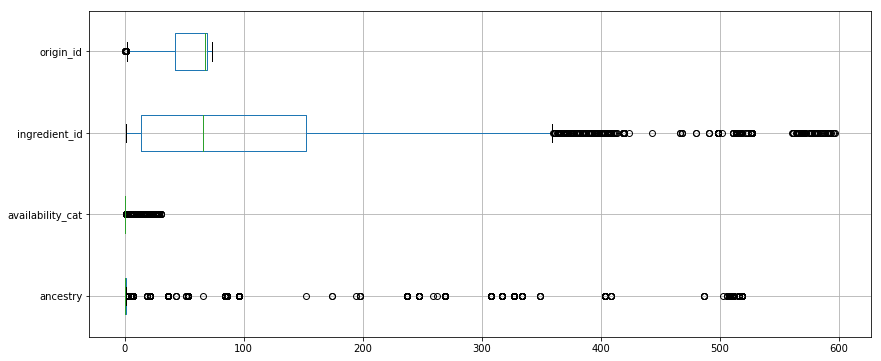

In [9]:
#plt.boxplot(cluster_data.iloc[:, 1:].T.to_numpy())
cluster_data.boxplot(column=['ancestry','availability_cat','ingredient_id','origin_id'], vert=False, figsize=(14,6))
plt.show()

### Standardize the Data

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X = cluster_data.drop(["recipe_title","rating"], axis=1)
x_std = ss.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### K-Means Clustering

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(algorithm='auto', n_clusters=5, max_iter=100, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [12]:
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

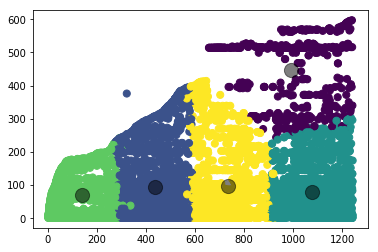

In [13]:
plt.scatter(X.recipe_id, X.ingredient_id, c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 3], c='black', s=200, alpha=0.5)
plt.show()

In [14]:
squared_distances_sum = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_std)
    squared_distances_sum.append(km.inertia_)

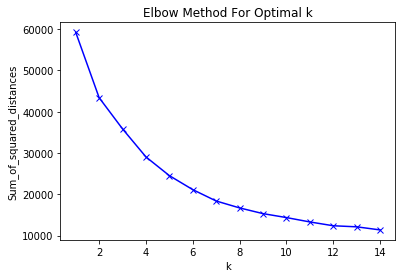

In [15]:
plt.plot(K, squared_distances_sum, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

- As shown with the Elbow method, optimal number of clusters is around k=5

### PCA for t-SNE model and data visualization

In [16]:
from sklearn.decomposition import PCA
pca_3 = PCA(n_components=3)
principal_components = pca_3.fit_transform(x_std)
principal_components

array([[-2.14838553,  0.96879176,  0.21413606],
       [-0.22391368,  0.73174539,  0.16735403],
       [-0.87490682,  0.81253361,  0.18534161],
       ...,
       [ 1.67942924, -0.57631501,  2.09160478],
       [ 2.03393137,  0.57541556,  1.68617665],
       [ 3.87964249, -0.01549517,  1.59374652]])

### t-SNE Clustering

In [17]:
from sklearn.manifold import TSNE
model = TSNE(n_components=3, learning_rate=100)
transformed = model.fit_transform(principal_components)

In [18]:
transformed

array([[  4.1825604,  -5.4996223,  13.50367  ],
       [-21.600346 ,   1.873239 ,  10.659211 ],
       [ -5.708653 ,  -5.0551047,  14.250418 ],
       ...,
       [ -3.899983 ,  13.85104  ,  -5.369854 ],
       [-11.465761 ,  23.827093 ,   3.9333608],
       [-10.670607 ,  15.649931 ,  -5.434088 ]], dtype=float32)

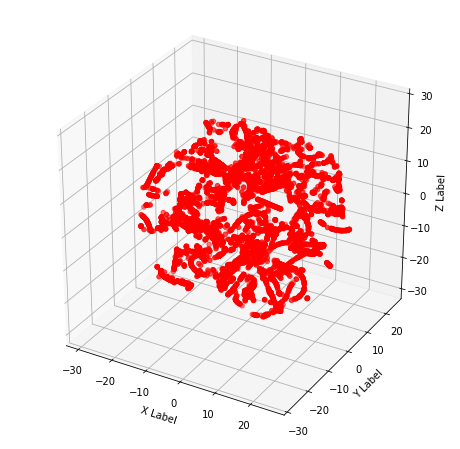

In [19]:
from mpl_toolkits.mplot3d import Axes3D
# Plotting 3d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
z_axis = transformed[:, 2]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x_axis, y_axis, z_axis, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

### DBSCAN Clustering

In [20]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=200)
dbscan.fit(x_std)

pca_2 = PCA(n_components=2).fit(x_std)
pca_2d = pca_2.transform(x_std)

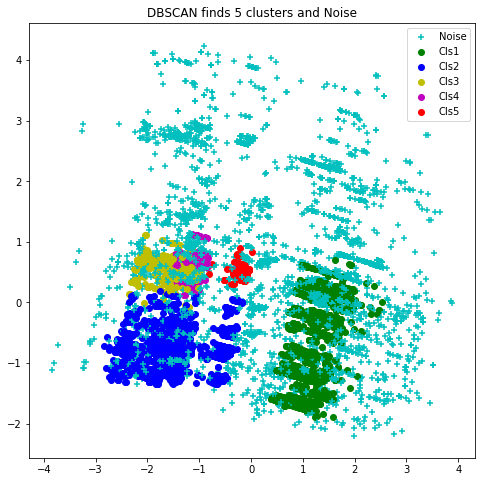

In [21]:
# Plot based on 5 Class and Noise
plt.figure(figsize=(8, 8))
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == -1:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='c', marker='+')
    elif dbscan.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == 1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='o')
    elif dbscan.labels_[i] == 2:
        c4 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='y', marker='o')
    elif dbscan.labels_[i] == 3:
        c5 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='m', marker='o')
    elif dbscan.labels_[i] == 4:
        c6 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='o')

plt.legend([c1, c2, c3, c4, c5, c6], ['Noise','Cls1', 'Cls2', 'Cls3', 'Cls4', 'Cls5'])
plt.title('DBSCAN finds 5 clusters and Noise')
plt.show()